In [1]:
import cPickle as pickle
import gzip
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pch
from brokenaxes import brokenaxes


In [2]:
fins = [
    "../output_fromJSON/pitches_2016.pkl.gz",
    "../output_fromJSON/pitches_2017.pkl.gz",
    "../output_fromJSON/pitches_2018.pkl.gz",
    "../output_fromJSON/pitches_2019.pkl.gz",
]
dfs = []
for fin in fins:
    dfs.append(pd.read_pickle(fin, compression="gzip"))
df = pd.concat(dfs, ignore_index=True)

print "shape:", df.shape

shape: (2819683, 66)


In [3]:
wb = df.query("pitcher==621111 & pitch_type!='UN' & pitch_type!='IN' & start_speed>0 & px>-999")
print wb.shape
wb["pitch_type"].value_counts()

(5100, 66)


FF    2458
SL     706
KC     683
FT     597
FC     557
CH      96
CU       3
Name: pitch_type, dtype: int64

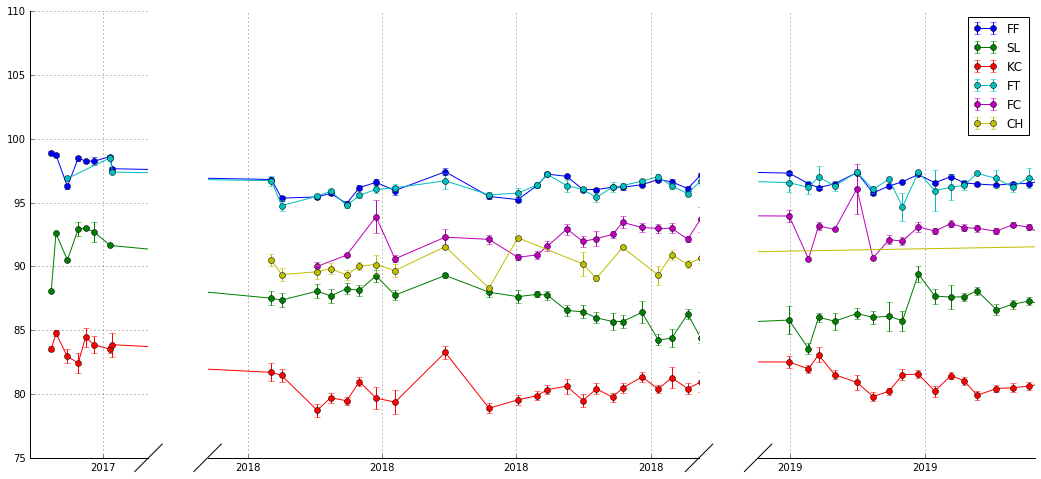

In [4]:
types = wb.groupby("pitch_type")
fig = plt.figure(figsize=(18,8))
bax = brokenaxes(xlims=((dt.datetime(2017,9,1),dt.datetime(2017,10,15)),
                        (dt.datetime(2018,4,1),dt.datetime(2018,10,1)),
                        (dt.datetime(2019,3,20),dt.datetime(2019,7,1))), hspace=1)
for name, group in sorted(types, key=lambda x:x[1].size, reverse=True):
    if group.shape[0] < 50:
        continue
    dates = group[["date","start_speed"]].groupby("date")
    means = dates.mean()
    stds = dates.std()
    counts = dates.count()
    bax.errorbar(means.index, means.values, yerr=stds.values/np.sqrt(counts.values), fmt='-o', label=name)
bax.set_ylim(75,110)
bax.grid(axis='both', which='major', ls=':')
bax.legend()

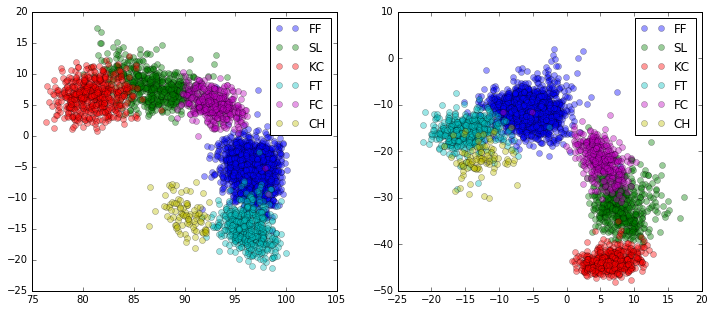

In [13]:
fix, axs = plt.subplots(1,2,figsize=(12,5))
for name, group in sorted(types, key=lambda x:x[1].size, reverse=True):
    if group.shape[0] < 50:
        continue
    axs[0].plot(group.start_speed.values, group.ax.values, 'o', alpha=0.4, label=name)
    axs[1].plot(group.ax.values, group.az.values, 'o', alpha=0.4, label=name)
axs[0].legend()
axs[1].legend()
    

array([7.9178637e-01, 1.0931826e-01, 5.1979974e-02, 3.3833031e-02,
       7.8295879e-03, 4.6316488e-03, 4.6653004e-04, 1.5459223e-04],
      dtype=float32)

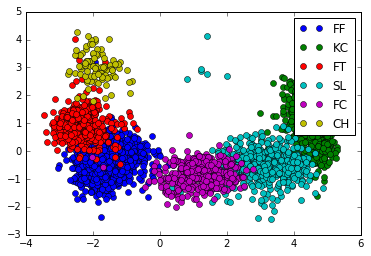

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
vals = wb.query("px>-999 & spin_rate>0")
types = vals.pitch_type
vals = vals[["start_speed","ax","ay","az","pfx_x","pfx_z","spin_rate","spin_dir"]]
p = Pipeline([
    ('scaler',StandardScaler()),
    ('pca', PCA())
])
trans = p.fit_transform(vals.values)
for typ in sorted(types.value_counts().index, key=lambda x:sum(types==x), reverse=True):
    idcs = types==typ
    if sum(idcs)<50:
        continue
    plt.plot(trans[idcs,0],trans[idcs,1],'o',label=typ)
plt.legend()
p.named_steps["pca"].explained_variance_ratio_